# BadNet Model



In [1]:
import tensorflow as tf
import keras
import keras.backend as K
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mount the google drive. Model is at`/content/drive/MyDrive/MLSproject`.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MLSproject
path = './models/bd_net.h5'
bad_model = keras.models.load_model(path)
bad_model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MLSproject
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)            

In [3]:
#current accurancy
!python original_eval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5

2021-12-14 15:28:56.238229: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


# Load datasets

In [4]:
#first try to load the datasets
data_path = '/content/drive/MyDrive/MLSproject/data/cl/test.h5'
data = h5py.File(data_path, 'r')
data.keys()

<KeysViewHDF5 ['data', 'label']>

In [5]:
cl_test_x = np.array(data['data'])
cl_test_y = np.array(data['label'])
print(cl_test_x.shape)
print(cl_test_y.shape)
print(f"Total classes:{len(set(cl_test_y))}")

(12830, 3, 55, 47)
(12830,)
Total classes:1283


In [6]:
#we need to transpose this dataset
cl_test_x = cl_test_x.transpose((0,2,3,1))
cl_test_x.shape

(12830, 55, 47, 3)

In [7]:
#define a function to load datasets
def load_data(path):
  '''
  Load dataset
  '''
  data = h5py.File(path, 'r')
  x = np.array(data['data'])
  y = np.array(data['label'])
  x = x.transpose((0,2,3,1))
  print(f"Load data from {path}: \tx:{x.shape}\ty: {y.shape}")
  return x, y

In [8]:
#Now load all test and validation datasets
cl_test_path = '/content/drive/MyDrive/MLSproject/data/cl/test.h5'
cl_test_x, cl_test_y = load_data(cl_test_path)
cl_valid_path = '/content/drive/MyDrive/MLSproject/data/cl/valid.h5'
cl_valid_x, cl_valid_y = load_data(cl_valid_path)
bd_test_path = '/content/drive/MyDrive/MLSproject/data/bd/bd_test.h5'
bd_test_x, bd_test_y = load_data(bd_test_path)
bd_valid_path = '/content/drive/MyDrive/MLSproject/data/bd/bd_valid.h5'
bd_valid_x, bd_valid_y = load_data(bd_valid_path)

Load data from /content/drive/MyDrive/MLSproject/data/cl/test.h5: 	x:(12830, 55, 47, 3)	y: (12830,)
Load data from /content/drive/MyDrive/MLSproject/data/cl/valid.h5: 	x:(11547, 55, 47, 3)	y: (11547,)
Load data from /content/drive/MyDrive/MLSproject/data/bd/bd_test.h5: 	x:(12830, 55, 47, 3)	y: (12830,)
Load data from /content/drive/MyDrive/MLSproject/data/bd/bd_valid.h5: 	x:(11547, 55, 47, 3)	y: (11547,)


# Prune the last pooling layer

In [9]:
#to prune the last pooling layer, should use conv_3
path = '/content/drive/MyDrive/MLSproject/models/bd_net.h5'
repaired_model = keras.models.load_model(path)
repaired_layer = repaired_model.get_layer('conv_3')
layer_model = keras.Model(inputs=repaired_model.input, outputs=repaired_layer.output)
#obtain average activation values
cl_output = np.mean(layer_model.predict(cl_valid_x), axis=0) 
#sort in increasing order by sum of values
cl_idx = np.argsort(np.sum(cl_output, axis=(0, 1))) 
print('Increasing index order:', cl_idx)

Increasing index order: [ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43  3 58 42  1 29 16  5 56
  8 11 46 54 10  4 18  7 28 35 52 57]


In [10]:
def accuracy(model, x, y):
    """
    Compute classification accuracy
    """
    y_pred = np.argmax(model.predict(x), axis=1)
    acc = np.mean(np.equal(y_pred, y))*100
    #print('Accuracy:', acc)
    return acc

In [11]:
#just define a repair function
def repair(X):
  '''
  X: percentage of accuracy reduced
  return two dictionary: keys: different percentages; values: clean accuracy/ attack success rate
  '''
  import copy
  #to prune the last pooling layer, should use conv_3
  path = '/content/drive/MyDrive/MLSproject/models/bd_net.h5'
  repaired_model = keras.models.load_model(path)
  repaired_layer = repaired_model.get_layer('conv_3')
  layer_model = keras.Model(inputs=repaired_model.input, outputs=repaired_layer.output)
  #obtain average activation values
  cl_output = np.mean(layer_model.predict(cl_valid_x), axis=0) 
  #sort in increasing order by sum of values
  cl_idx = np.argsort(np.sum(cl_output, axis=(0, 1))) 
  weight, bias = repaired_layer.get_weights()

  iter = 0
  acc_cl = []
  attack_sr = []
  #dictionary store every accuracy and attack sr for different x
  acc_x = {}
  attack_x ={}
  ori_acc = accuracy(bad_model, cl_valid_x, cl_valid_y)
  ori_attack_rate = accuracy(repaired_model, bd_test_x, bd_test_y)
  percentages = copy.deepcopy(X)
  

  for i in cl_idx:
      weight[:, :, :, i] = 0
      bias[i] = 0
      repaired_layer.set_weights([weight, bias])
      iter += 1
      #because of the limited memory, the first 30 iterations won't compute accuracy, because there are no change
      if iter >30:
        acc = accuracy(repaired_model, cl_valid_x, cl_valid_y) 
        attack_rate = accuracy(repaired_model, bd_test_x, bd_test_y)
      else:
        acc = ori_acc
        attack_rate = ori_attack_rate
      acc_cl.append(acc)
      attack_sr.append(attack_rate)
      print(f'iteration {iter}: accuracy {acc:.2f}%, attack success rate: {attack_rate:.2f}%')
      #check the percentage of prune
      while percentages:
        x = percentages[0]
        if ori_acc - acc >= x*100:
          #should use deepcopy
          acc_x[x] = copy.deepcopy(acc_cl)
          attack_x[x] = copy.deepcopy(attack_sr)
          print(f"Prune {x*100}% with accuracy {acc:.2f}%, attack success rate: {attack_rate:.2f}%")
          #pass the first percentage
          repaired_model.save('/content/drive/MyDrive/MLSproject/models/repaired_net_'+str(x*100)+'.h5')
          percentages.pop(0)
        else:
          break
  #print(f"Completed with accuracy {acc:.2f}%, attack success rate: {attack_rate:.2f}%")
  #prune_channel = i+1

  return acc_x, attack_x


In [12]:
#X = {2%,4%,10%,30%}
X=[0.02,0.04,0.1,0.3]
acc_x, attack_x = repair(X)
print(acc_x,attack_x)

iteration 1: accuracy 98.65%, attack success rate: 100.00%
iteration 2: accuracy 98.65%, attack success rate: 100.00%
iteration 3: accuracy 98.65%, attack success rate: 100.00%
iteration 4: accuracy 98.65%, attack success rate: 100.00%
iteration 5: accuracy 98.65%, attack success rate: 100.00%
iteration 6: accuracy 98.65%, attack success rate: 100.00%
iteration 7: accuracy 98.65%, attack success rate: 100.00%
iteration 8: accuracy 98.65%, attack success rate: 100.00%
iteration 9: accuracy 98.65%, attack success rate: 100.00%
iteration 10: accuracy 98.65%, attack success rate: 100.00%
iteration 11: accuracy 98.65%, attack success rate: 100.00%
iteration 12: accuracy 98.65%, attack success rate: 100.00%
iteration 13: accuracy 98.65%, attack success rate: 100.00%
iteration 14: accuracy 98.65%, attack success rate: 100.00%
iteration 15: accuracy 98.65%, attack success rate: 100.00%
iteration 16: accuracy 98.65%, attack success rate: 100.00%
iteration 17: accuracy 98.65%, attack success rat

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


iteration 46: accuracy 95.20%, attack success rate: 99.98%
iteration 47: accuracy 94.78%, attack success rate: 99.98%
iteration 48: accuracy 94.34%, attack success rate: 99.98%
Prune 4.0% with accuracy 94.34%, attack success rate: 99.98%
iteration 49: accuracy 93.85%, attack success rate: 99.98%
iteration 50: accuracy 92.16%, attack success rate: 80.58%
iteration 51: accuracy 89.17%, attack success rate: 80.65%
iteration 52: accuracy 84.44%, attack success rate: 77.21%
Prune 10.0% with accuracy 84.44%, attack success rate: 77.21%
iteration 53: accuracy 76.49%, attack success rate: 36.27%
iteration 54: accuracy 45.69%, attack success rate: 16.03%
Prune 30.0% with accuracy 45.69%, attack success rate: 16.03%
iteration 55: accuracy 28.15%, attack success rate: 3.73%
iteration 56: accuracy 13.80%, attack success rate: 16.40%
iteration 57: accuracy 5.81%, attack success rate: 0.30%
iteration 58: accuracy 1.55%, attack success rate: 0.00%
iteration 59: accuracy 0.72%, attack success rate: 0.

# Plot the results
Plot the accuracy on clean test data and the attack success rate (on backdoored test
data) as a function of the fraction of channels pruned.

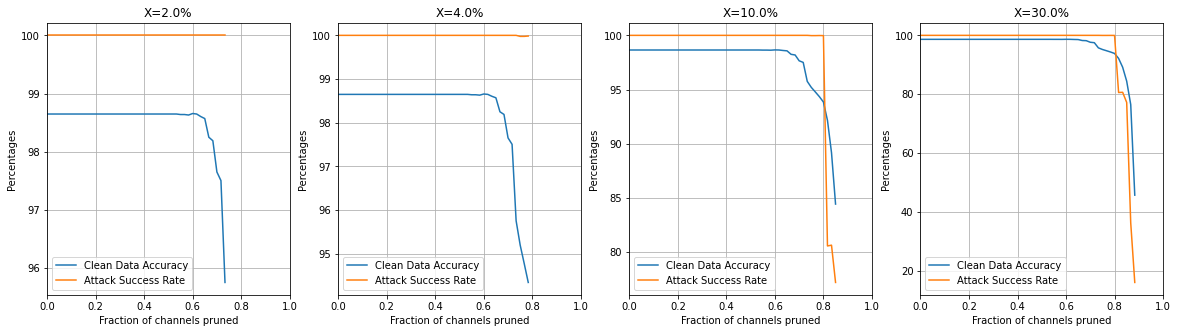

In [21]:
# plot the accuracy
channels = len(cl_idx)
length = len(X)
plt.figure(figsize=(20, 5))
for i,x in enumerate(X):
  acc_cl = acc_x[x]
  attack_sr = attack_x[x]
  x_values = [i/channels for i in range(len(acc_cl))]
  plt.subplot(1,length, i+1)
  plt.plot(x_values, acc_cl, label="Clean Data Accuracy")
  plt.plot(x_values, attack_sr, Label="Attack Success Rate")
  plt.xlabel('Fraction of channels pruned')
  plt.ylabel('Percentages')
  plt.xlim(0,1)
  #plt.ylim(0,100)
  plt.title('X='+str(x*100)+"%")
  plt.legend()
  plt.grid('on')
plt.show()

# Comments

As shown in figures above, the pruning defense didn't work well for this model. Because when the clean data accuracy dropped about 10%, the attack success rate only dropped to 77%. And if we want the attack success rate be reduced to 10%, then the clean data accurary will be also rapidly reduced to 45%. The result is not good for defender. Thus I think this defense is not working.

# GoodNet Model


In [15]:
#the total number of classes
N = len(set(cl_test_y))
print(N)

1283


In [16]:
path = './models/bd_net.h5'
bad_model = keras.models.load_model(path)

In [17]:
def GoodNet(bad_model, repaired_model, data, N=N):
    """
    GoodNet:
    For each test input, you will run it through both bad_model and repaired_model. 
    If the classification outputs are the same, i.e., class i, you will output class i. 
    If they differ you will output N+1.
    """
    y_pred_bad = np.argmax(bad_model.predict(data), axis=1)
    y_pred_repaired = np.argmax(repaired_model.predict(data), axis=1)
    y_hat = [y_pred_bad[i] if y_pred_bad[i] == y_pred_repaired[i] else N for i in range(len(y_pred_bad))]
    count = 0
    for i in range(len(y_pred_bad)):
      if y_pred_bad[i] != y_pred_repaired[i]:
        count +=1
        print(f"Predicted Class: Bad Net: {y_pred_bad[i]}, Repaired Net: {y_pred_repaired[i]}, Good Net: {y_hat[i]}")
    print(f'There are {count} backdoored inputs predicted as new class {N} now.')

    
    return y_hat

In [18]:
bad_path = '/content/drive/MyDrive/MLSproject/models/bd_net.h5'
repaired_path = '/content/drive/MyDrive/MLSproject/models/repaired_net_2.0.h5'
bad_model = keras.models.load_model(bad_path)
repaired_model = keras.models.load_model(repaired_path)
prediction = GoodNet(bad_model,repaired_model, cl_test_x, N)

Predicted Class: Bad Net: 823, Repaired Net: 415, Good Net: 1283
Predicted Class: Bad Net: 819, Repaired Net: 957, Good Net: 1283
Predicted Class: Bad Net: 754, Repaired Net: 410, Good Net: 1283
Predicted Class: Bad Net: 1276, Repaired Net: 66, Good Net: 1283
Predicted Class: Bad Net: 529, Repaired Net: 25, Good Net: 1283
Predicted Class: Bad Net: 736, Repaired Net: 648, Good Net: 1283
Predicted Class: Bad Net: 214, Repaired Net: 543, Good Net: 1283
Predicted Class: Bad Net: 214, Repaired Net: 543, Good Net: 1283
Predicted Class: Bad Net: 302, Repaired Net: 952, Good Net: 1283
Predicted Class: Bad Net: 823, Repaired Net: 1092, Good Net: 1283
Predicted Class: Bad Net: 1142, Repaired Net: 211, Good Net: 1283
Predicted Class: Bad Net: 478, Repaired Net: 667, Good Net: 1283
Predicted Class: Bad Net: 1143, Repaired Net: 1154, Good Net: 1283
Predicted Class: Bad Net: 1163, Repaired Net: 520, Good Net: 1283
Predicted Class: Bad Net: 612, Repaired Net: 213, Good Net: 1283
Predicted Class: Bad 

# Evaluate
The repaired networks will be evaluated
using the evaluation script (eval.py) on this website https://github.com/csaw-hackml/
CSAW-HackML-2020.

In [24]:
#X = 2%
!python original_eval.py data/cl/test.h5 data/bd/bd_test.h5 models/repaired_net_2.0.h5

2021-12-14 15:39:26.720611: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 15:39:27.190236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification accuracy: 95.90023382696803
2021-12-14 15:39:29.815306: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 100.0


In [25]:
#X = 4%
!python original_eval.py data/cl/test.h5 data/bd/bd_test.h5 models/repaired_net_4.0.h5

2021-12-14 15:41:29.102857: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 15:41:31.553592: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification accuracy: 94.77007014809041
2021-12-14 15:41:34.193735: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 99.98441153546376


In [26]:
#X = 10%
!python original_eval.py data/cl/test.h5 data/bd/bd_test.h5 models/repaired_net_10.0.h5

2021-12-14 15:41:54.795073: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 15:41:57.998685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification accuracy: 84.54403741231489
2021-12-14 15:42:00.604936: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 77.20966484801247


In [27]:
#X = 30%
!python original_eval.py data/cl/test.h5 data/bd/bd_test.h5 models/repaired_net_30.0.h5

2021-12-14 15:42:19.543650: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 15:42:22.009519: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification accuracy: 44.67653936087295
2021-12-14 15:42:24.647665: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 16.03273577552611
